## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [13]:
import pandas as pd

In [14]:
df = pd.read_csv(r"C:\Users\Tombra\train.csv\train - Copy.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [15]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [16]:
df.shape

(319512, 6)

### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [17]:
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords and initialize stemmer
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Convert non-string columns to strings
df['question1'] = df['question1'].astype(str)
df['question2'] = df['question2'].astype(str)

# Combine two text columns into a single column
df['combined_text'] = df['question1'] + df['question2']

# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Stopwords cleaning and punctuation removal
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token not in string.punctuation]
    
    # Normalization (optional, can be skipped depending on the use case)
    tokens = [token.lower() for token in tokens]
    
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_text

# Apply preprocessing function to the combined text column
df['preprocessed_text'] = df['combined_text'].apply(preprocess_text)

# Example usage: Create a bag-of-words representation using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['preprocessed_text'])

# X now contains the vectorized representation of the preprocessed text data


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [18]:
import gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')

# Tokenize the text data
sentences = [nltk.word_tokenize(text) for text in df['combined_text']]

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Save the trained model
model.save(r"C:\Users\Tombra\word2vec\model.bin")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
features = df['combined_text']
labels = df['is_duplicate']

In [21]:
import gensim
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import string

nltk.download('punkt')
nltk.download('stopwords')

# Calculate TF-IDF
# Set the parameters
max_features = 2500
min_df = 7
max_df = 0.8
stop_words = nltk_stopwords.words('english')  # Use nltk_stopwords instead of stopwords

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df, stop_words=stop_words)

# Fit the vectorizer to the features data
tfidf_vectorizer.fit(features)

# Transform the features using the fitted vectorizer
vectorized_features = tfidf_vectorizer.transform(features)

# Load the Word2Vec model
model = gensim.models.Word2Vec.load(r"C:\Users\Tombra\word2vec\model.bin")

def calculate_word2vec_similarity(text1, text2):
    tokens1 = nltk.word_tokenize(text1)
    tokens2 = nltk.word_tokenize(text2)
    # Remove stopwords and punctuation
    stopwords = set(nltk_stopwords.words('english'))
    tokens1 = [token.lower() for token in tokens1 if token.lower() not in stopwords and token not in string.punctuation]
    tokens2 = [token.lower() for token in tokens2 if token.lower() not in stopwords and token not in string.punctuation]
    
    # Check if any of the lists is empty
    if not tokens1 or not tokens2:
        return 0.0
    
    # Calculate similarity using Word2Vec model
    similarity = model.wv.n_similarity(tokens1, tokens2)
    return similarity

df['word2vec_similarity'] = df.apply(lambda row: calculate_word2vec_similarity(row['question1'], row['question2']), axis=1)

# Calculate word count
df['word_count'] = df['preprocessed_text'].apply(lambda text: len(text.split()))

# Calculate the number of the same words in the combined text column
df['same_word_count'] = df['combined_text'].apply(lambda text: len(set(nltk.word_tokenize(text.lower()))) if text else 0)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df['word_count'] = df['preprocessed_text'].apply(lambda text: len(text.split()))


In [23]:
word_count_counts = df['word_count'].value_counts()


In [24]:
word_count_counts

8      33193
10     29985
9      29723
6      27327
7      26191
       ...  
66         1
128        1
67         1
73         1
54         1
Name: word_count, Length: 80, dtype: int64

### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


# Reduce the number of samples
df_sampled = df.sample(n=10000, random_state=42)  # Adjust the number of samples as needed

# Define the features and labels columns
features = 'combined_text'
labels = 'is_duplicate'

# Split the sampled data into features and labels
X = df_sampled[features]
y = df_sampled[labels]

# Split the features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test = vectorizer.transform(X_test)

# Create a logistic regression model
logreg_model = LogisticRegression()

# Fit the model to the training data
logreg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = logreg_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Generate confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(confusion_matrix)



Accuracy: 0.7125
Precision: 0.6985743380855397
Recall: 0.44545454545454544
F1-Score: 0.5440126883425852
Confusion Matrix:
[[1082  148]
 [ 427  343]]


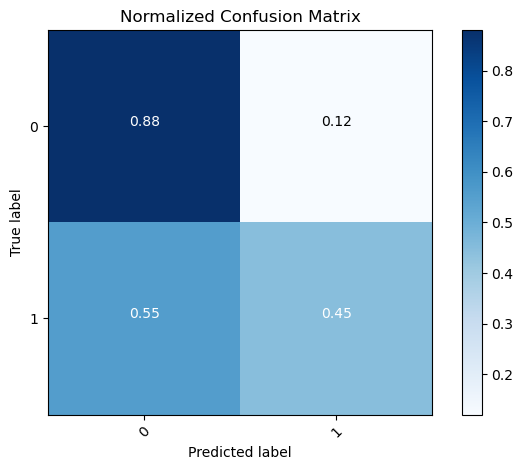

Accuracy: 0.7125
Precision: 0.6985743380855397
Recall: 0.44545454545454544
F1-Score: 0.5440126883425852
Confusion Matrix:
[[1082  148]
 [ 427  343]]


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = unique_labels(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Confusion Matrix:")
print(conf_mat)


In [12]:

#improve model accuracy and precision

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Create a logistic regression model
logreg_model = LogisticRegression()

# Create a GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new logistic regression model with the best hyperparameters
best_logreg_model = LogisticRegression(**best_params)

# Fit the new model to the training data
best_logreg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_logreg_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print (accuracy)
print (precision)
print (recall)
print (f1)


0.7125
0.6985743380855397
0.44545454545454544
0.5440126883425852


c:\Users\Tombra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Tombra\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Tombra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Tombra\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
V

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Define the hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2']
}

# Create a logistic regression model
logreg_model = LogisticRegression(solver='lbfgs')

# Create a GridSearchCV object
grid_search = GridSearchCV(logreg_model, param_grid, cv=5)

# Fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new logistic regression model with the best hyperparameters
best_logreg_model = LogisticRegression(solver='lbfgs', **best_params)

# Fit the new model to the training data
best_logreg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = best_logreg_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

# Generate the classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)


Accuracy: 0.7125
Precision: 0.6985743380855397
Recall: 0.44545454545454544
F1-Score: 0.5440126883425852
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.88      0.79      1230
           1       0.70      0.45      0.54       770

    accuracy                           0.71      2000
   macro avg       0.71      0.66      0.67      2000
weighted avg       0.71      0.71      0.70      2000



In [27]:

#using XGBOOST

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reduce the number of samples
df_sampled = df.sample(n=10000, random_state=42)  # Adjust the number of samples as needed

# Define the features and labels columns
features = 'combined_text'
labels = 'is_duplicate'

# Split the sampled data into features and labels
X = df_sampled[features]
y = df_sampled[labels]

# Split the features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test = vectorizer.transform(X_test)

# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.709
Precision: 0.6530944625407166
Recall: 0.5207792207792208
F1-Score: 0.5794797687861272


In [45]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Reduce the number of samples
df_sampled = df.sample(n=10000, random_state=42)  # Adjust the number of samples as needed

# Define the features and labels columns
features = 'combined_text'
labels = 'is_duplicate'

# Split the sampled data into features and labels
X = df_sampled[features]
y = df_sampled[labels]

# Split the features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test = vectorizer.transform(X_test)

# Create an XGBoost classifier
xgb_model = XGBClassifier()

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)

# Generate the classification report
report = classification_report(y_test, y_pred)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78      1230
           1       0.65      0.52      0.58       770

    accuracy                           0.71      2000
   macro avg       0.69      0.67      0.68      2000
weighted avg       0.70      0.71      0.70      2000



In [16]:
#using ensemble modelling

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Reduce the number of samples
df_sampled = df.sample(n=10000, random_state=42)  # Adjust the number of samples as needed

# Define the features and labels columns
features = 'combined_text'
labels = 'is_duplicate'

# Split the sampled data into features and labels
X = df_sampled[features]
y = df_sampled[labels]

# Split the features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data
X_train = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test = vectorizer.transform(X_test)

# Create individual models
logreg_model = LogisticRegression()
xgb_model = XGBClassifier()

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('logreg', logreg_model), ('xgb', xgb_model)])

# Fit the ensemble model to the training data
ensemble_model.fit(X_train, y_train)

# Evaluate the ensemble model
y_pred = ensemble_model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.707
Precision: 0.7628571428571429
Recall: 0.34675324675324676
F1-Score: 0.4767857142857143


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

# Define the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('feature_selection', SelectKBest(chi2)),
    ('classification', RandomForestClassifier())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'tfidf__max_features': [5000, 10000, 20000],  # Adjust the number of features as needed
    'feature_selection__k': [100, 500, 1000],  # Adjust the number of top features as needed
    'classification__n_estimators': [100, 200, 300],
    'classification__max_depth': [None, 5, 10],
    'classification__min_samples_split': [2, 5, 10]
}

# Reduce the number of samples (if needed) and define the features and labels columns
df_sampled = df.sample(n=10000, random_state=42)
features = 'combined_text'
labels = 'is_duplicate'
X = df_sampled[features]
y = df_sampled[labels]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model with the tuned hyperparameters
best_model = grid_search.best_estimator_

# Evaluate the best model on the testing data
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [79]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2

X = df_sampled[features]
y = df_sampled[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [19]:
k = 1000  # Number of top features to select
selector = SelectKBest(chi2, k=k)
X_train = selector.fit_transform(X_train, y_train)
X_test = selector.transform(X_test)


In [20]:
rf_model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}


In [21]:
grid_search = GridSearchCV(rf_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 5, 10],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]})

In [22]:
best_rf_model = grid_search.best_estimator_


In [23]:
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)


In [24]:
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.6915
Precision: 0.6335078534031413
Recall: 0.4714285714285714
F1 Score: 0.5405807892777363


In [35]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Reduce the number of samples
df_sampled = df.sample(n=10000, random_state=42)  # Adjust the number of samples as needed

# Define the features and labels columns
features = 'combined_text'
labels = 'is_duplicate'

# Split the sampled data into features and labels
X = df_sampled[features]
y = df_sampled[labels]

# Split the features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = max([len(seq) for seq in X_train_seq])
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Create the LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=10, batch_size=32)

# Evaluate the model
y_pred_probs = model.predict(X_test_padded)
y_pred = (y_pred_probs > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Epoch 1/10
250/250 [==============================] - 18s 66ms/step - loss: 0.6097 - accuracy: 0.6700
Epoch 2/10
250/250 [==============================] - 18s 74ms/step - loss: 0.4476 - accuracy: 0.7951
Epoch 3/10
250/250 [==============================] - 18s 71ms/step - loss: 0.2955 - accuracy: 0.8748
Epoch 4/10
250/250 [==============================] - 18s 74ms/step - loss: 0.1895 - accuracy: 0.9229
Epoch 5/10
250/250 [==============================] - 20s 80ms/step - loss: 0.1266 - accuracy: 0.9495
Epoch 6/10
250/250 [==============================] - 21s 82ms/step - loss: 0.0879 - accuracy: 0.9638
Epoch 7/10
250/250 [==============================] - 19s 78ms/step - loss: 0.0643 - accuracy: 0.9749
Epoch 8/10
250/250 [==============================] - 20s 79ms/step - loss: 0.0443 - accuracy: 0.9833
Epoch 9/10
250/250 [==============================] - 21s 83ms/step - loss: 0.0290 - accuracy: 0.9895
Epoch 10/10
63/63 [==============================] - 5s 20ms/step
Accuracy: 0.6445

In [31]:
#testing the models with new data
#import the testing data

df_test = pd.read_csv(r"C:\Users\Tombra\train.csv\test.csv")


In [32]:

#cleaning the data

import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

# Download stopwords and initialize stemmer
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Convert non-string columns to strings
df_test['question1'] = df_test['question1'].astype(str)
df_test['question2'] = df_test['question2'].astype(str)

# Combine two text columns into a single column
df_test['combined_text'] = df_test['question1'] + df_test['question2']

# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)
    
    # Stopwords cleaning and punctuation removal
    tokens = [token.lower() for token in tokens if token.lower() not in stopwords and token not in string.punctuation]
    
    # Normalization (optional, can be skipped depending on the use case)
    tokens = [token.lower() for token in tokens]
    
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    # Join tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)
    
    return preprocessed_text

# Apply preprocessing function to the combined text column
df_test['preprocessed_text'] = df_test['combined_text'].apply(preprocess_text)

# Example usage: Create a bag-of-words representation using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_test['preprocessed_text'])

# X now contains the vectorized representation of the preprocessed text data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
features_test = df_test['combined_text']
labels_test = df_test['is_duplicate']

In [38]:
import gensim
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import string

nltk.download('punkt')
nltk.download('stopwords')

# Calculate TF-IDF
# Set the parameters
max_features = 2500
min_df = 7
max_df = 0.8
stop_words = nltk_stopwords.words('english')  # Use nltk_stopwords instead of stopwords

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df, stop_words=stop_words)

# Fit the vectorizer to the features data
tfidf_vectorizer.fit(features_test)

# Transform the features using the fitted vectorizer
vectorized_features_test= tfidf_vectorizer.transform(features_test)

# Load the Word2Vec model
model_test = gensim.models.Word2Vec.load(r"C:\Users\Tombra\word2vec\model.bin")

def calculate_word2vec_similarity(text1, text2):
    tokens1 = nltk.word_tokenize(text1)
    tokens2 = nltk.word_tokenize(text2)
    # Remove stopwords and punctuation
    stopwords = set(nltk_stopwords.words('english'))
    tokens1 = [token.lower() for token in tokens1 if token.lower() not in stopwords and token not in string.punctuation]
    tokens2 = [token.lower() for token in tokens2 if token.lower() not in stopwords and token not in string.punctuation]
    
    # Check if any of the lists is empty
    if not tokens1 or not tokens2:
        return 0.0
    
    # Calculate similarity using Word2Vec model
    similarity = model_test.wv.n_similarity(tokens1, tokens2)
    return similarity

df_test['word2vec_similarity'] = df_test.apply(lambda row: calculate_word2vec_similarity(row['question1'], row['question2']), axis=1)

# Calculate word count
df_test['word_count'] = df_test['preprocessed_text'].apply(lambda text: len(text.split()))

# Calculate the number of the same words in the combined text column
df_test['same_word_count'] = df_test['combined_text'].apply(lambda text: len(set(nltk.word_tokenize(text.lower()))) if text else 0)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tombra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
df_test.dtypes

id                       int64
qid1                     int64
qid2                     int64
question1               object
question2               object
is_duplicate             int32
combined_text           object
preprocessed_text       object
word2vec_similarity    float64
word_count               int64
same_word_count          int64
dtype: object

In [50]:
# Preprocess the new test data
X_test = df_test['combined_text']
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Predict with the LSTM model
y_pred_probs_test = model.predict(X_test_padded)
y_pred_test = (y_pred_probs_test > 0.5).astype(int)

# Calculate evaluation metrics on the new test dataset
accuracy_test = accuracy_score(df_test['is_duplicate'], y_pred_test)
precision_test = precision_score(df_test['is_duplicate'], y_pred_test)
recall_test = recall_score(df_test['is_duplicate'], y_pred_test)
f1_test = f1_score(df_test['is_duplicate'], y_pred_test)

print("Accuracy (Test):", accuracy_test)
print("Precision (Test):", precision_test)
print("Recall (Test):", recall_test)
print("F1-Score (Test):", f1_test)


2650/2650 [==============================] - 50s 19ms/step
Accuracy (Test): 0.6527636886928212
Precision (Test): 0.5149125630297179
Recall (Test): 0.6284124386252046
F1-Score (Test): 0.5660288350974438
